In [1]:
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

import mlgrad.af as af
import mlgrad.funcs as funcs
import mlgrad.funcs2 as funcs2
import mlgrad.models as models
import mlgrad.loss as loss
import mlgrad.boost.robanyboost as robanyboost
import mlgrad.boost.anyboost as anyboost
import mlgrad.inventory as inventory

In [2]:
N = 100
X1, Y1 = datasets.make_moons(N, noise=0.3)
Y1 = 2*Y1-1
Y1 = Y1.astype("d")

# X2, Y2 = datasets.make_moons(30, noise=0.05)
# Y2 = 2*Y2-1
# Y2 = -Y2.astype("d")

# for i in range(10):
#     if Y2[i] == 1:
#         X2[i,1] += 0.15
#     else:
#         X2[i,1] -= 0.15

# X = np.concatenate((X1, X2), axis=0)
# Y = np.concatenate((Y1, Y2), axis=0)
X = X1
Y = Y1

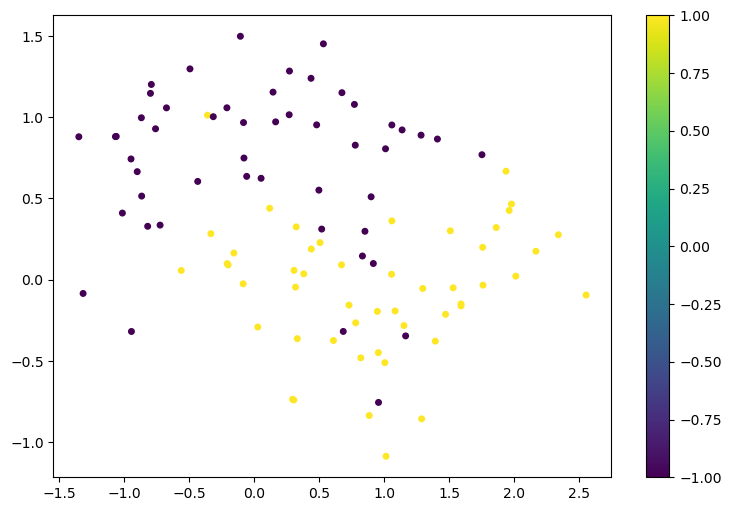

In [3]:
plt.figure(figsize=(9,6))
sc = plt.scatter(X[:,0], X[:,1], c=Y, s=16)
plt.colorbar(sc)
plt.show()

In [4]:
def sigmoidal_factory(n):
    return models.SigmaNeuronModel(funcs.Sigmoidal(5.0), n)

In [5]:
shrink = 0.01
n_classifier = 200

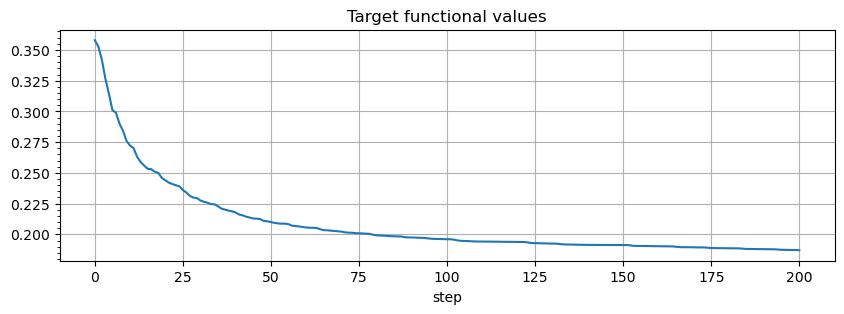

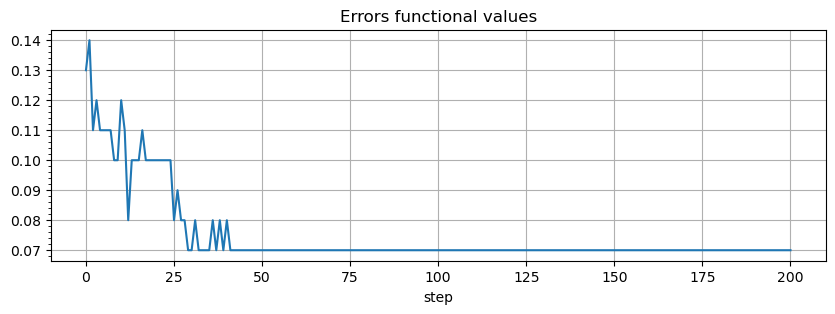

In [6]:
cls = anyboost.AnyBoostClassification(
    func=funcs.SoftHinge_Exp(1.0), 
    model_factory=sigmoidal_factory, 
    shrink=shrink,
    # min_weak_learn_score=0.01,
    n_classifier=n_classifier)
cls.fit(X, Y, regnorm=funcs2.SquareNorm(), tau=0.1)

plt.figure(figsize=(10,3))
plt.title("Target functional values")
plt.plot(cls.lvals)
plt.xlabel("step")
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.show()

plt.figure(figsize=(10,3))
plt.title("Errors functional values")
plt.plot(cls.errvals)
plt.xlabel("step")
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.show()


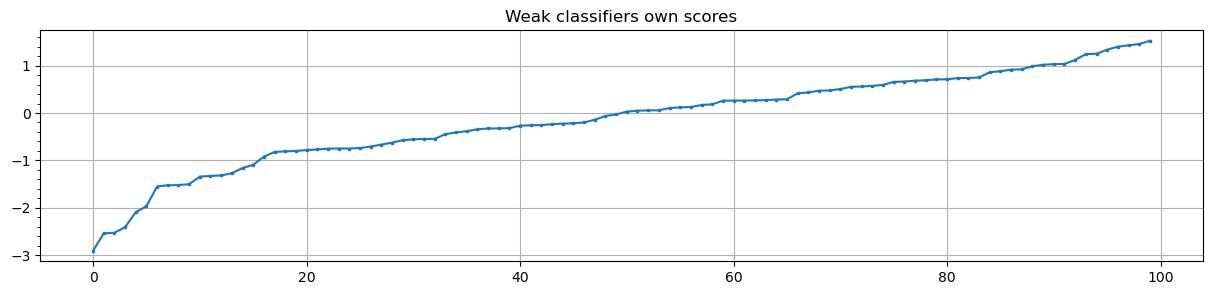

In [7]:
M = Y*cls.H.evaluate(X)
Z = inventory.modified_zscore(M)

plt.figure(figsize=(15,3))
plt.title("Weak classifiers own scores")
# plt.plot(sorted(M), marker='s', markersize=2)
plt.plot(sorted(Z), marker='s', markersize=2)
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.show()

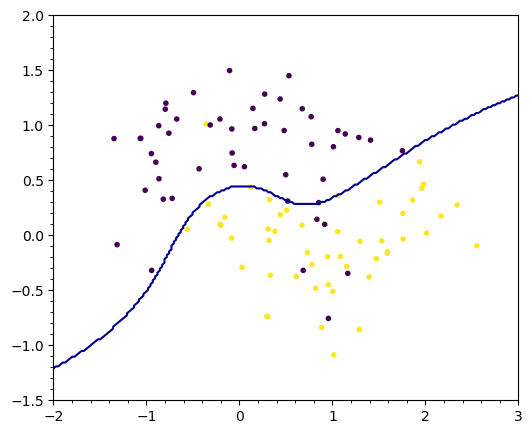

In [8]:
XX, YY = np.meshgrid(np.linspace(-2.0, 3.0, 200), np.linspace(-1.5, 2.0, 200))
XY = np.c_[XX.ravel(), YY.ravel()]

plt.figure(figsize=(6,5))
ZZ = np.sign(cls.H.evaluate(XY))
ZZ = ZZ.reshape(XX.shape)
plt.scatter(X[:,0], X[:,1], c=Y, s=9)
plt.contour(ZZ, extent=(-2.0, 3.0, -1.5, 2.0), levels=[0], colors=["darkblue"])
plt.minorticks_on()
plt.show()

0.99


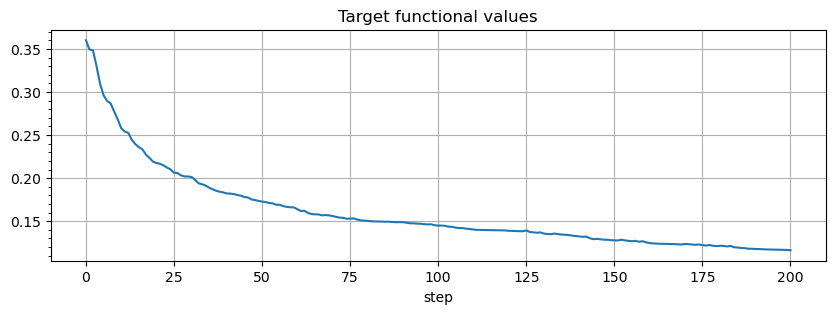

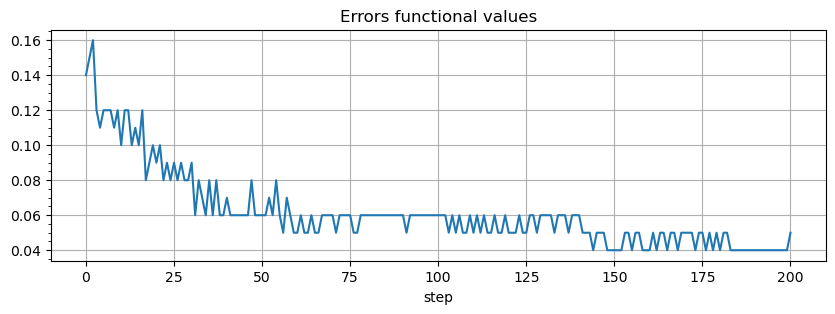

In [9]:
alpha = (N-1) / N
print(alpha)

cls2 = robanyboost.RobustAnyBoostClassification(
    aggfunc=af.averaging_function("WM", funcs.QuantileFunc(alpha, funcs.SoftAbs_Sqrt(0.001))),
    func=funcs.SoftHinge_Exp(), 
    model_factory=sigmoidal_factory, 
    shrink=shrink,
    # min_weak_learn_score=0.01,
    n_classifier=n_classifier)
cls2.fit(X, Y, regnorm=funcs2.SquareNorm(), tau=0.0)

plt.figure(figsize=(10,3))
plt.title("Target functional values")
plt.plot(cls2.lvals)
plt.xlabel("step")
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.show()

plt.figure(figsize=(10,3))
plt.title("Errors functional values")
plt.plot(cls2.errvals)
plt.xlabel("step")
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.show()

# plt.figure(figsize=(10,3))
# plt.title("Weak classifiers own scores")
# plt.plot(cls2.wl_lvals)
# plt.xlabel("index")
# ax = plt.gca()
# ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
# plt.grid(1)
# plt.show()

In [10]:
# plt.figure(figsize=(12,3))
# plt.title("Weak classifier weights")
# plt.bar(range(len(cls.H.weights)), cls.H.weights)
# plt.minorticks_on()
# plt.show()

In [11]:
# plt.figure(figsize=(12,3))
# plt.title("Weak classifier weights")
# plt.bar(range(len(cls2.H.weights)), cls2.H.weights)
# plt.minorticks_on()
# plt.show()

In [12]:
# scores = np.array([metrics.accuracy_score(np.sign(mod.evaluate(X)),Y) for mod in cls.H.models])
# scores2 = np.array([metrics.accuracy_score(np.sign(mod.evaluate(X)),Y) for mod in cls2.H.models])

In [13]:
# plt.figure(figsize=(12,3))
# plt.title(f"Weak classifiers accuracy scores (>0.5: {(scores>0.5).sum()}; <0.5: {(scores<0.5).sum()})")
# plt.vlines(range(len(scores)), 0, scores)
# plt.hlines(0.5, 0, len(scores), colors='grey', linestyles='--')
# plt.minorticks_on()
# plt.show()

In [14]:
# plt.figure(figsize=(12,3))
# plt.title(f"Weak classifiers accuracy scores (>0.5: {(scores2>0.5).sum()}; <0.5: {(scores2<0.5).sum()})")
# plt.vlines(range(len(scores2)), 0, scores2)
# plt.hlines(0.5, 0, len(scores2), colors='grey', linestyles='--')
# plt.minorticks_on()
# plt.show()

In [15]:
accuracy = metrics.accuracy_score(np.sign(cls.H.evaluate(X)),Y)
accuracy2 = metrics.accuracy_score(np.sign(cls2.H.evaluate(X)),Y)

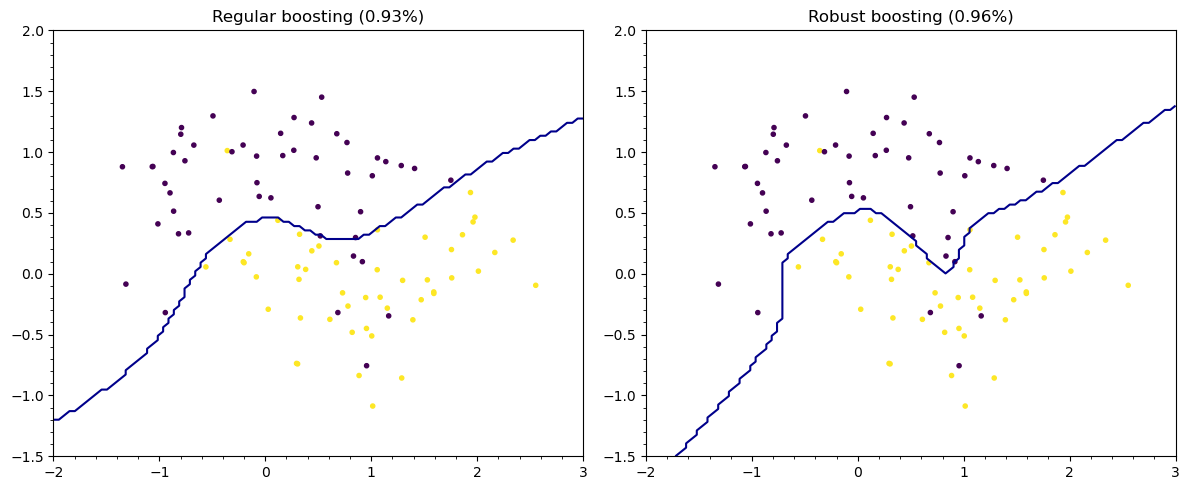

In [16]:
XX, YY = np.meshgrid(np.linspace(-2.0, 3.0, 100), np.linspace(-1.5, 2.0, 100))
XY = np.c_[XX.ravel(), YY.ravel()]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title(f"Regular boosting ({accuracy:.2f}%)")
ZZ = np.sign(cls.H.evaluate(XY))
ZZ = ZZ.reshape(XX.shape)
plt.scatter(X[:,0], X[:,1], c=Y, s=9)
plt.contour(ZZ, extent=(-2.0, 3.0, -1.5,2.0), levels=[0], colors=["darkblue"])
plt.minorticks_on()
plt.subplot(1,2,2)
plt.title(f"Robust boosting ({accuracy2:.2f}%)")
ZZ2 = np.sign(cls2.H.evaluate(XY))
ZZ2 = ZZ2.reshape(XX.shape)
plt.scatter(X[:,0], X[:,1], c=Y, s=9)
plt.contour(ZZ2, extent=(-2.0, 3.0, -1.5,2.0), levels=[0], colors=["darkblue"])
plt.minorticks_on()
plt.savefig("fig/robanyboost_1.eps")
plt.tight_layout()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


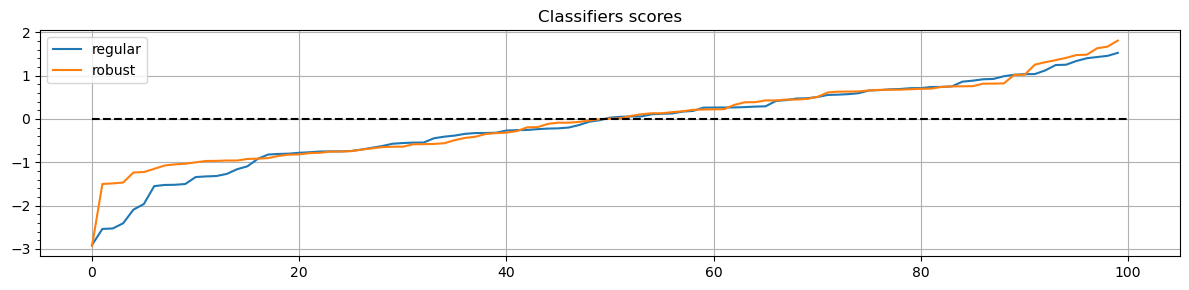

In [17]:
M2 = Y*cls2.H.evaluate(X)
Z2 = inventory.modified_zscore(M2)

plt.figure(figsize=(12,3))
plt.title("Classifiers scores")
plt.plot(sorted(Z), label='regular')
plt.plot(sorted(Z2), label='robust')
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.legend()
plt.hlines(0, 0, N, colors='k', linestyles='--')
plt.savefig("fig/robanyboost_2.eps")
plt.tight_layout()
plt.show()

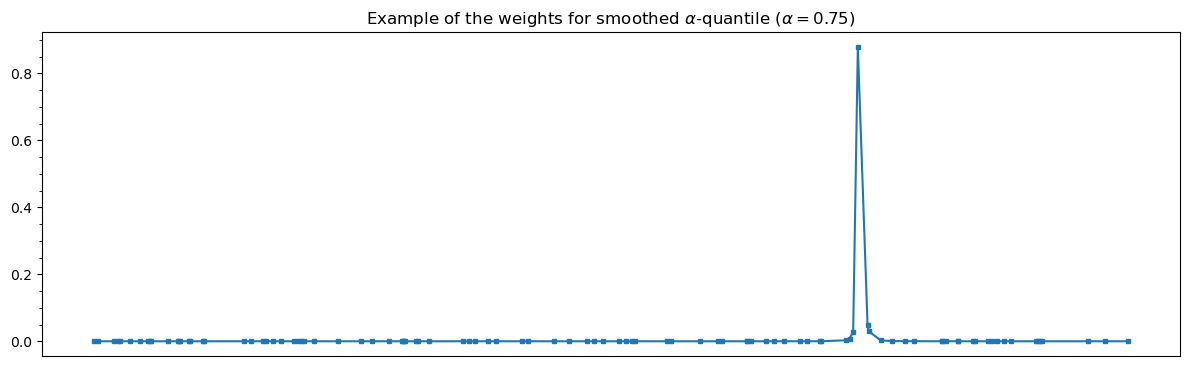

In [18]:
V = np.random.random(100)
V.sort()
aggfunc=af.averaging_function("M", funcs.QuantileFunc(0.75, funcs.SoftAbs_Sqrt(0.001)))

plt.figure(figsize=(12,4))
plt.title(r"Example of the weights for smoothed $\alpha$-quantile ($\alpha=0.75$)")
plt.plot(V, aggfunc.gradient(V), marker='s', markersize=3)
plt.savefig("fig/quantile_weights.eps")
plt.tight_layout()
plt.minorticks_on()
plt.xticks([])
plt.show()

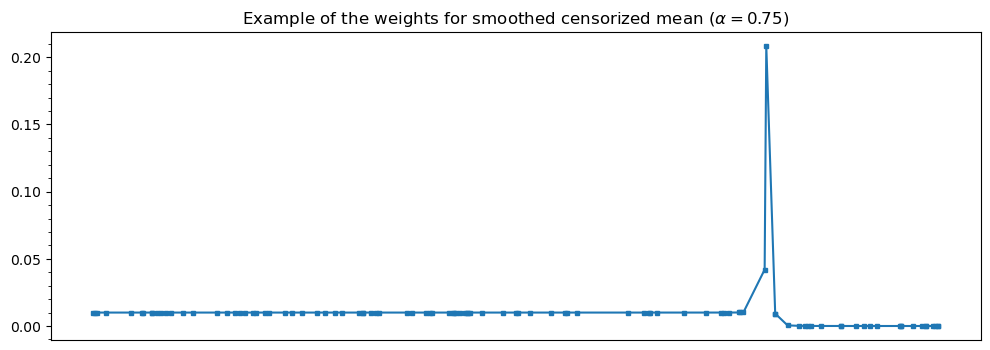

In [19]:
V = np.random.random(100)
V.sort()
aggfunc=af.averaging_function("WM", funcs.QuantileFunc(0.75, funcs.SoftAbs_Sqrt(0.001)))

plt.figure(figsize=(12,4))
plt.title(r"Example of the weights for smoothed censorized mean ($\alpha=0.75$)")
plt.plot(V, aggfunc.gradient(V), marker='s', markersize=3)
plt.savefig("fig/cp_weights.eps")
plt.minorticks_on()
plt.xticks([])
plt.show()

In [20]:
import scipy.optimize as opt